# Brief analysis on model fit with a larger data set

## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
from pathlib import Path
from time import time
from typing import Final

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import scipy.stats as st
import seaborn as sns

In [3]:
from speclet.bayesian_models.hierarchical_nb import HierarchcalNegativeBinomialModel
from speclet.io import DataFile, models_dir
from speclet.managers.data_managers import CrisprScreenDataManager
from speclet.plot.plotnine_helpers import set_gg_theme
from speclet.project_configuration import read_project_configuration

In [4]:
# Notebook execution timer.
notebook_tic = time()

# Plotting setup.
set_gg_theme()
%config InlineBackend.figure_format = "retina"

# Constants
RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = read_project_configuration().modeling.highest_density_interval

## Data

In [5]:
posterior_summary_path = (
    models_dir() / "hierarchical-nb_PYMC3_MCMC" / "posterior-summary.csv"
)
assert posterior_summary_path.exists()
posterior_summary = pd.read_csv(posterior_summary_path).assign(
    parameter_name=lambda d: [x.split("[")[0] for x in d.parameter]
)
posterior_summary.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name
0,z,0.042,0.005,0.035,0.050,0.000,0.000,142.0,404.0,1.02,z
1,a[0],0.314,0.087,0.165,0.439,0.001,0.001,4659.0,2956.0,1.00,a
2,a[1],-0.004,0.060,-0.106,0.085,0.001,0.001,2523.0,3087.0,1.00,a
3,a[2],0.179,0.060,0.087,0.279,0.001,0.001,2254.0,2605.0,1.00,a
4,a[3],0.196,0.065,0.097,0.303,0.001,0.001,3222.0,2927.0,1.00,a


In [6]:
hnb_model_cls = HierarchcalNegativeBinomialModel()
dm = CrisprScreenDataManager(DataFile.DEPMAP_CRC_BONE_LARGE_SUBSAMPLE)
counts_data = dm.get_data().pipe(hnb_model_cls.data_processing_pipeline)
counts_data.head()

/var/folders/r4/qpcdgl_14hbd412snp1jnv300000gn/T/ipykernel_86735/3319598406.py:3: DtypeWarning: Columns (3,22) have mixed types.Specify dtype option on import or set low_memory=False.


,sgrna,replicate_id,lfc,p_dna_batch,genome_alignment,hugo_symbol,screen,multiple_hits_on_gene,sgrna_target_chr,sgrna_target_pos,...,is_mutated,copy_number,lineage,primary_or_metastasis,is_male,age,counts_final_total,counts_initial_total,counts_final_rpm,counts_initial_adj
0,AAAGCCCAGGAGTATGGGAG,LS513-311Cas9_RepA_p6_batch2,0.594321,2,chr2_130522105_-,CFC1B,broad,True,2,130522105,...,False,0.951337,colorectal,primary,True,63.0,35176093,1.072163e+06,13.309497,257.442323
1,ACTTGTCTCATGAACGTGAT,LS513-311Cas9_RepA_p6_batch2,0.475678,2,chr2_86917638_+,RGPD1,broad,True,2,86917638,...,False,0.949234,colorectal,primary,True,63.0,35176093,1.072163e+06,37.928490,766.756365
2,AGAAACTTCACCCCTTTCAT,LS513-311Cas9_RepA_p6_batch2,0.296108,2,chr16_18543661_+,NOMO2,broad,True,16,18543661,...,False,0.944648,colorectal,primary,True,63.0,35176093,1.072163e+06,29.513684,685.044642
3,AGCTGAGCGCAGGGACCGGG,LS513-311Cas9_RepA_p6_batch2,-0.020788,2,chr1_27012633_-,TENT5B,broad,True,1,27012633,...,False,0.961139,colorectal,primary,True,63.0,35176093,1.072163e+06,4.837834,142.977169
4,ATACTCCTGGGCTTTCGGAG,LS513-311Cas9_RepA_p6_batch2,-0.771298,2,chr2_130522124_+,CFC1B,broad,True,2,130522124,...,False,0.951337,colorectal,primary,True,63.0,35176093,1.072163e+06,14.588775,706.908890


In [7]:
data_coords = hnb_model_cls._model_coords(counts_data)

cell_line_lineage_map = (
    counts_data[["depmap_id", "lineage"]].drop_duplicates().reset_index(drop=True)
)

sgrna_gene_map = (
    counts_data[["sgrna", "hugo_symbol"]].drop_duplicates().reset_index(drop=True)
)

## Analysis

### Sampling diagnostics

#### R-hat

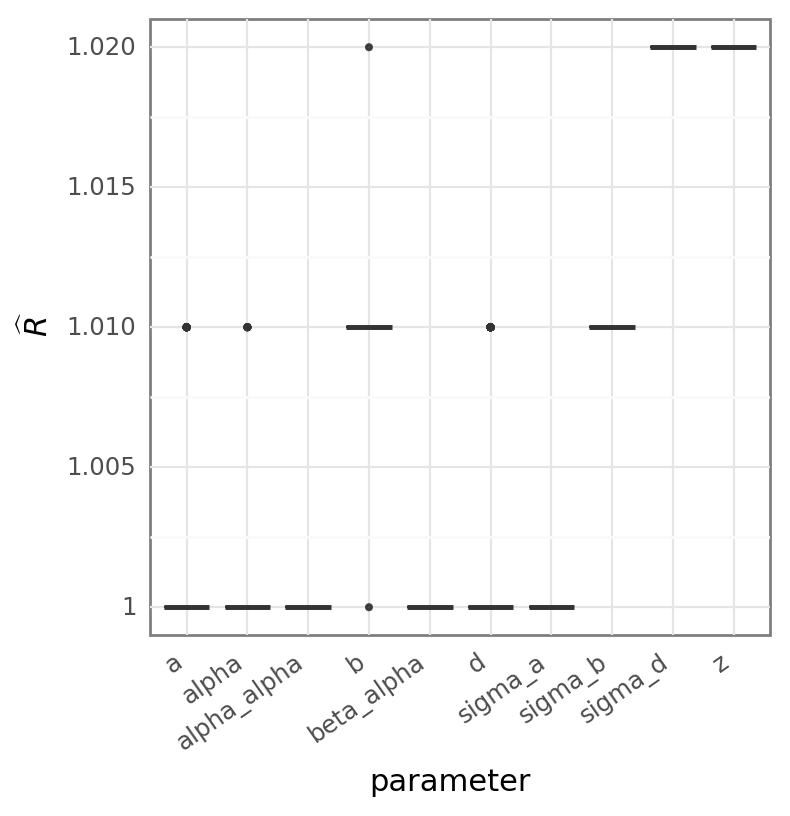

<ggplot: (365124428)>

In [8]:
(
    gg.ggplot(posterior_summary, gg.aes(x="parameter_name", y="r_hat"))
    + gg.geom_boxplot(outlier_size=0.6, outlier_alpha=0.5)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="$\widehat{R}$")
)

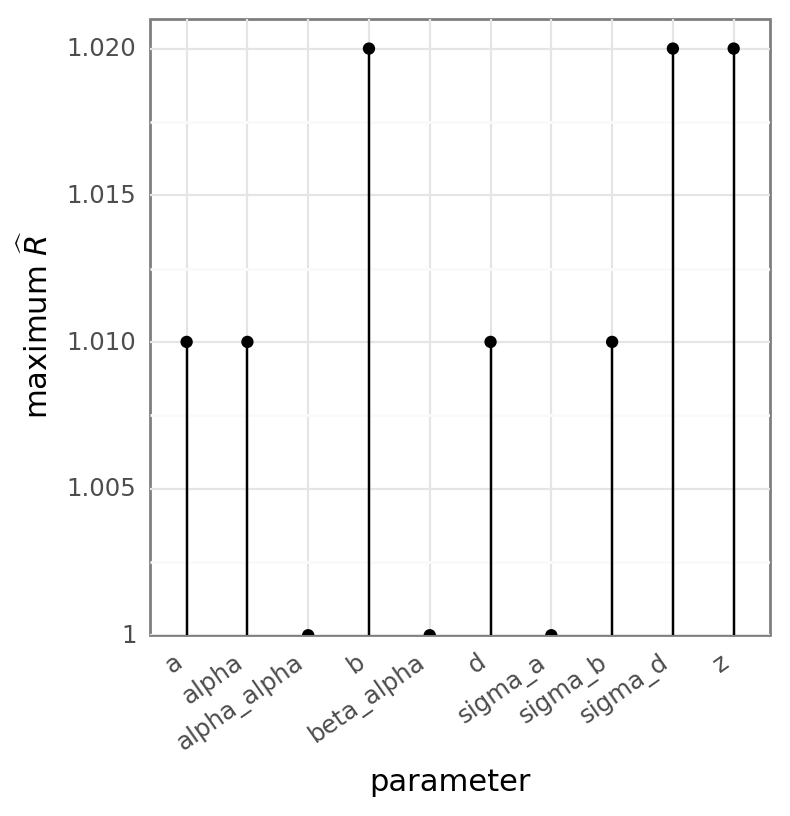

<ggplot: (365126903)>

In [9]:
max_r_hats = (
    posterior_summary.sort_values("r_hat", ascending=False)
    .groupby("parameter_name")
    .head(1)
)
(
    gg.ggplot(max_r_hats, gg.aes(x="parameter_name", y="r_hat"))
    + gg.geom_linerange(gg.aes(ymax="r_hat"), ymin=1)
    + gg.geom_point()
    + gg.scale_y_continuous(expand=(0, 0, 0.05, 0))
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="maximum $\widehat{R}$")
)

#### ESS

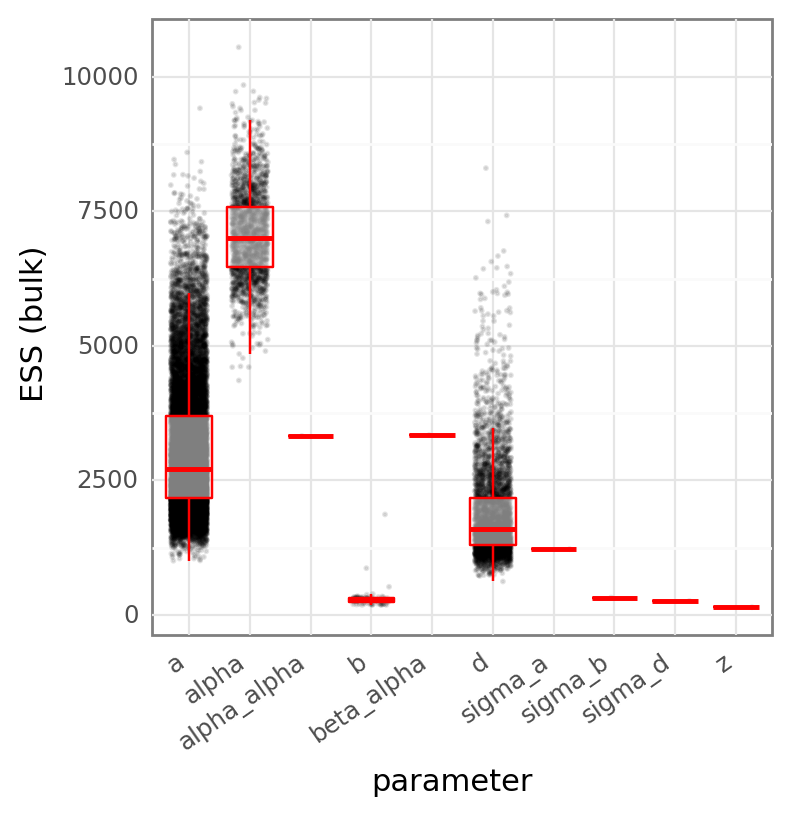

<ggplot: (361860259)>

In [10]:
(
    gg.ggplot(
        posterior_summary,
        gg.aes(x="parameter_name", y="ess_bulk"),
    )
    + gg.geom_jitter(alpha=0.1, size=0.2, width=0.3, height=0)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.5, color="red")
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="ESS (bulk)")
)

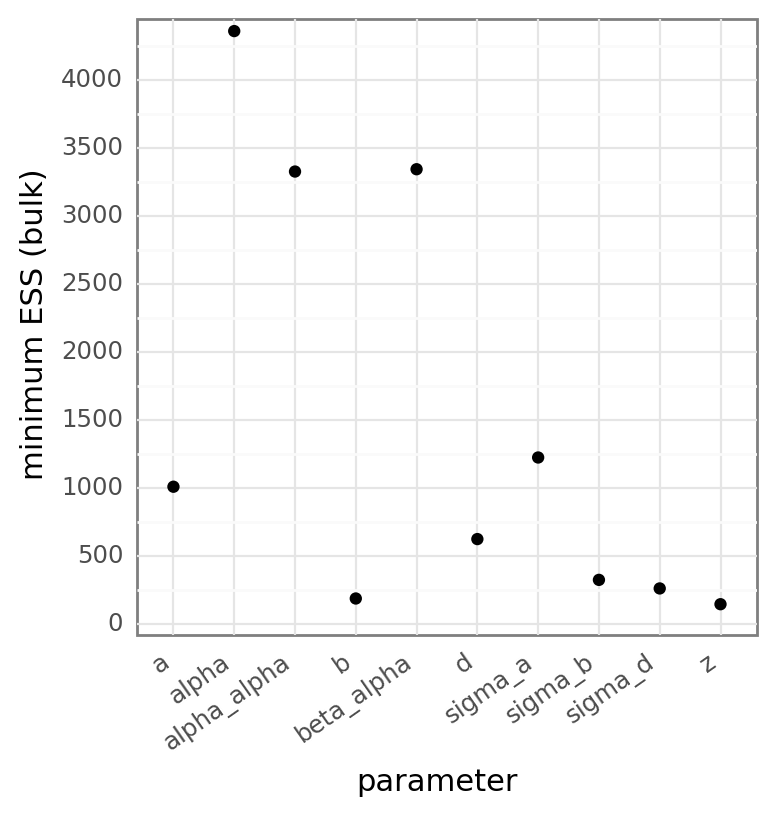

<ggplot: (361862864)>

In [11]:
min_ess = (
    posterior_summary.sort_values("ess_bulk", ascending=True)
    .groupby("parameter_name")
    .head(1)
)

_breaks = np.arange(0, 5000, 500)

(
    gg.ggplot(min_ess, gg.aes(x="parameter_name", y="ess_bulk"))
    + gg.geom_linerange(gg.aes(ymax="r_hat"), ymin=1)
    + gg.geom_point()
    + gg.scale_y_continuous(expand=(0.02, 0), breaks=_breaks)
    + gg.theme(axis_text_x=gg.element_text(angle=35, hjust=1))
    + gg.labs(x="parameter", y="minimum ESS (bulk)")
)

### Parameter posteriors

#### $b$: cell line

In [12]:
lineage_pal: Final[dict[str, str]] = {"bone": "darkviolet", "colorectal": "green"}

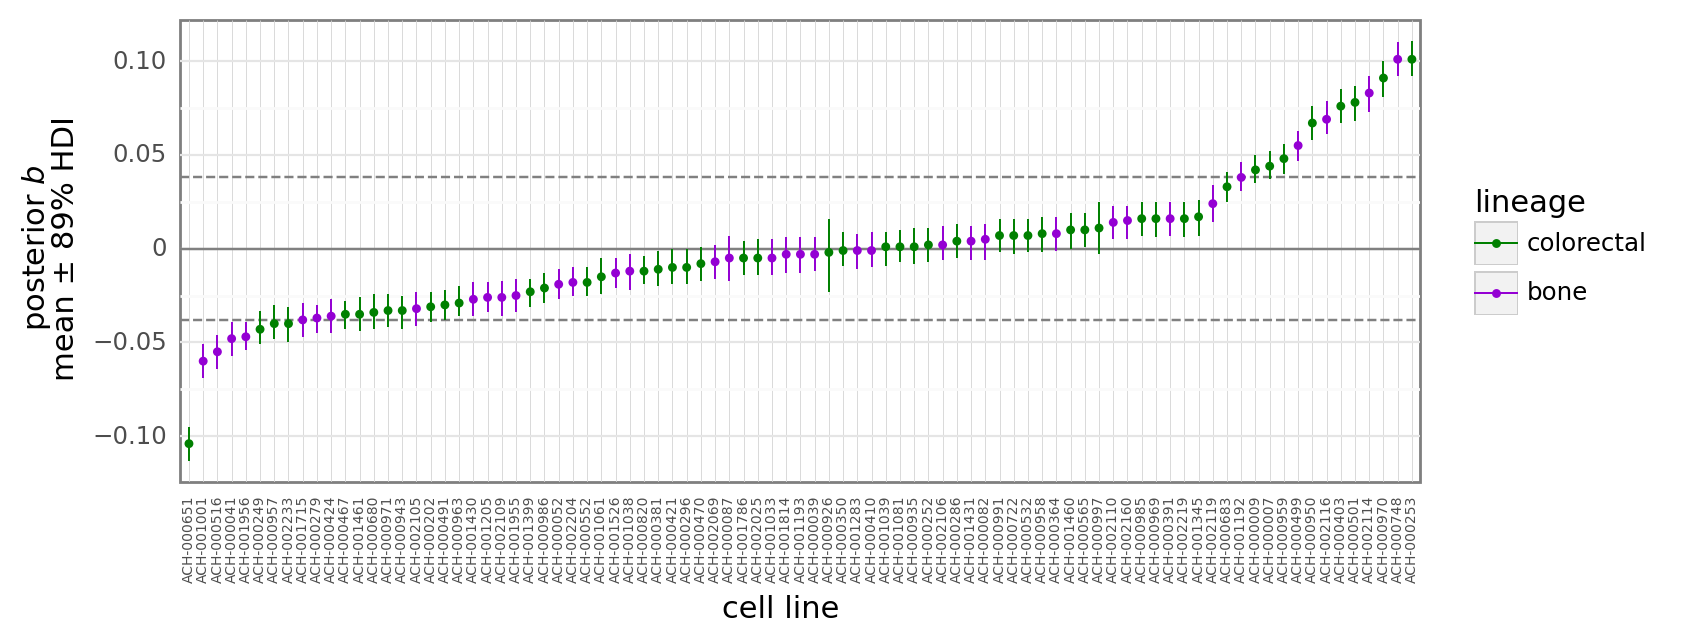

<ggplot: (362756109)>

In [13]:
sigma_b_map = posterior_summary.query("parameter_name == 'sigma_b'")["mean"].values[0]

b_posterior = (
    posterior_summary.query("parameter_name == 'b'")
    .reset_index(drop=True)
    .assign(depmap_id=data_coords["cell_line"])
    .merge(cell_line_lineage_map, on="depmap_id")
    .sort_values(["mean"])
    .assign(
        depmap_id=lambda d: pd.Categorical(
            d.depmap_id.values, categories=d.depmap_id.values, ordered=True
        )
    )
)

(
    gg.ggplot(b_posterior, gg.aes(x="depmap_id", y="mean"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_hline(yintercept=[-sigma_b_map, sigma_b_map], linetype="--", color="gray")
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="lineage"), size=0.4
    )
    + gg.geom_point(gg.aes(color="lineage"), size=0.8)
    + gg.scale_color_manual(values=lineage_pal)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=5),
        panel_grid_major_x=gg.element_line(size=0.3, color="lightgray"),
        figure_size=(8, 3),
    )
    + gg.labs(x="cell line", y="posterior $b$\nmean ± 89% HDI")
)

#### $a$: sgRNA

In [14]:
a_posterior = (
    posterior_summary.query("parameter_name == 'a'")
    .reset_index(drop=True)
    .assign(sgrna=data_coords["sgrna"])
    .merge(sgrna_gene_map, on="sgrna")
)
a_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna,hugo_symbol
0,a[0],0.314,0.087,0.165,0.439,0.001,0.001,4659.0,2956.0,1.0,a,CCCGCAGGATTCAGCACCT,CD79B
1,a[1],-0.004,0.060,-0.106,0.085,0.001,0.001,2523.0,3087.0,1.0,a,GTGGGGAACACATCTAAGG,STAMBP
2,a[2],0.179,0.060,0.087,0.279,0.001,0.001,2254.0,2605.0,1.0,a,TGAGTCTGGGGACGAGACG,MESP1
3,a[3],0.196,0.065,0.097,0.303,0.001,0.001,3222.0,2927.0,1.0,a,TGATTCCTTGGCAGGAGTA,CER1
4,a[4],0.173,0.078,0.058,0.304,0.001,0.001,3788.0,3091.0,1.0,a,TTATACCTCAATATCCCTC,FBXL20


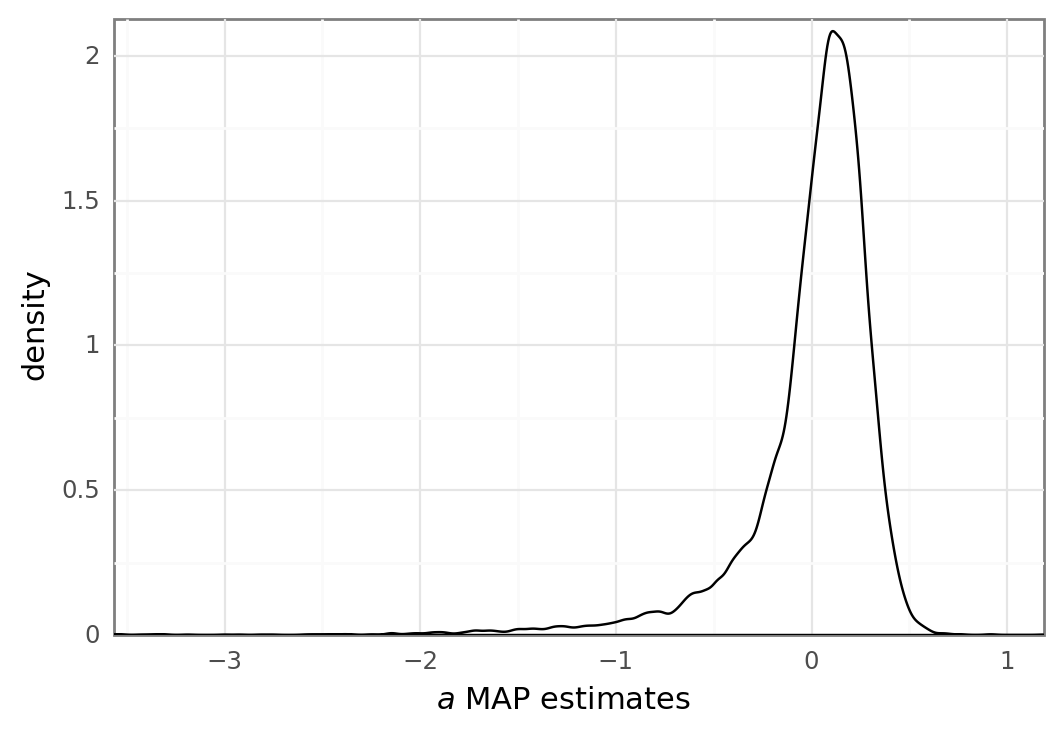

<ggplot: (363625469)>

In [15]:
(
    gg.ggplot(a_posterior, gg.aes(x="mean"))
    + gg.geom_density()
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.theme(figure_size=(6, 4))
    + gg.labs(x="$a$ MAP estimates")
)

In [16]:
def min_max(df: pd.DataFrame, n: int, drop_idx: bool = True) -> pd.DataFrame:
    """Get the top and botton `n` rows of a data frame."""
    return pd.concat([df.head(n), df.tail(n)]).reset_index(drop=drop_idx)


_n_top = 20
a_min_max = (
    a_posterior.sort_values("mean")
    .pipe(min_max, n=_n_top)
    .assign(
        sgrna=lambda d: pd.Categorical(
            d.sgrna.values, categories=d.sgrna.values, ordered=True
        )
    )
)
a_min_max.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna,hugo_symbol
0,a[348],-3.567,0.145,-3.790,-3.337,0.002,0.001,5820.0,2632.0,1.0,a,GCATGACTTGTGATAAAGA,CLHC1
1,a[9682],-3.536,0.149,-3.758,-3.285,0.002,0.001,5308.0,3123.0,1.0,a,TACCACCCTGATGAGTAAC,TAP2
2,a[16025],-3.531,0.142,-3.772,-3.311,0.002,0.001,5369.0,2937.0,1.0,a,TCCCAGCTAGCCATGCTGCA,ANGPT4
3,a[349],-3.428,0.143,-3.645,-3.193,0.002,0.001,5352.0,3065.0,1.0,a,AGTTACATCCACAAATGCCT,HEPHL1
4,a[6869],-3.379,0.137,-3.585,-3.154,0.002,0.001,5291.0,2788.0,1.0,a,TGGCTGCCTTAGCTGAAGGA,TAF15


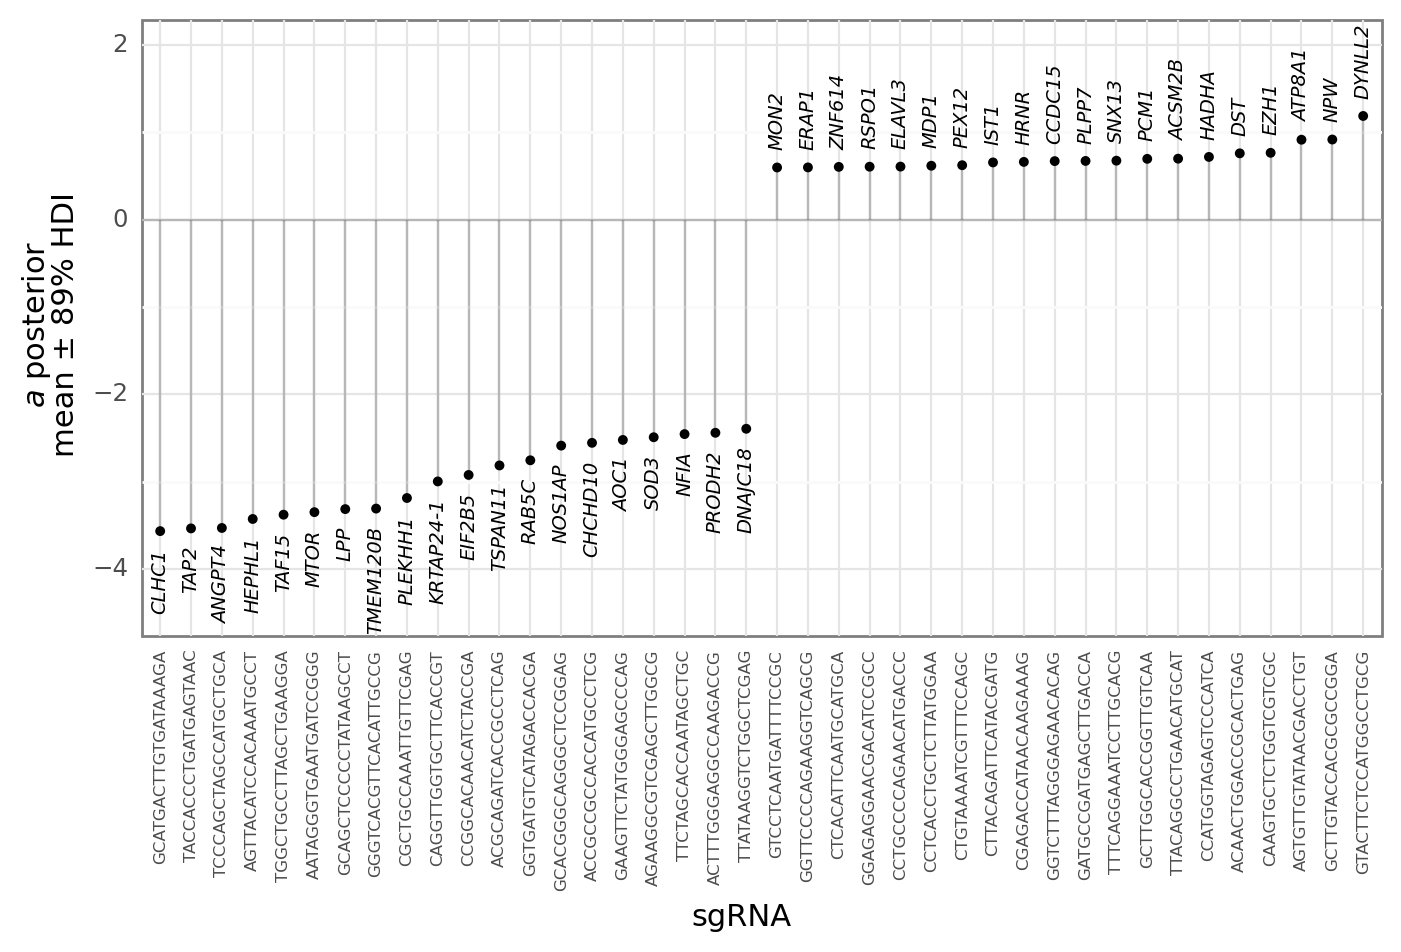

<ggplot: (364341553)>

In [17]:
_nudge_y = [-0.2 for _ in range(_n_top)] + [0.2 for _ in range(_n_top)]
_va = ["top" for _ in range(_n_top)] + ["bottom" for _ in range(_n_top)]
(
    gg.ggplot(a_min_max, gg.aes(x="sgrna", y="mean"))
    + gg.geom_hline(yintercept=0, alpha=0.2)
    + gg.geom_linerange(gg.aes(ymin=0, ymax="mean"), alpha=0.2)
    + gg.geom_point(size=1)
    + gg.geom_text(
        gg.aes(label="hugo_symbol"),
        size=7,
        angle=90,
        nudge_y=_nudge_y,
        va=_va,
        fontstyle="italic",
    )
    + gg.scale_y_continuous(expand=(0, 1.0, 0, 0.9))
    + gg.theme(figure_size=(8, 4), axis_text_x=gg.element_text(angle=90, size=6))
    + gg.labs(x="sgRNA", y="$a$ posterior\nmean ± 89% HDI")
)

In [18]:
a_post_gene_avg = (
    a_posterior.groupby("hugo_symbol")["mean"]
    .median()
    .reset_index(drop=False)
    .sort_values("mean")
    .reset_index(drop=True)
)

_n_top = 20
a_post_gene_avg_minmax = a_post_gene_avg.pipe(min_max, n=_n_top)

_gene_order = a_post_gene_avg_minmax.hugo_symbol.values.astype(str)

a_post_gene_avg_minmax = (
    a_post_gene_avg_minmax.rename(columns={"mean": "gene_mean"})
    .merge(a_posterior, on="hugo_symbol", how="left")
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.values, categories=_gene_order, ordered=True
        )
    )
)

a_post_gene_avg_minmax.head()

,hugo_symbol,gene_mean,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,sgrna
0,KCNE1,-0.8200,a[8308],0.026,0.054,-0.062,0.110,0.001,0.001,1897.0,2708.0,1.0,a,CTACATCGAGTCCGATGCC
1,KCNE1,-0.8200,a[13640],-1.666,0.115,-1.859,-1.491,0.001,0.001,6115.0,2932.0,1.0,a,GCTTGCCGTCACTGCTGCG
2,RTL8A,-0.6585,a[2278],-1.762,0.206,-2.107,-1.444,0.003,0.002,6398.0,2881.0,1.0,a,AGCGCGCGCGGCACGATGGA
3,RTL8A,-0.6585,a[7956],0.445,0.076,0.328,0.572,0.001,0.001,3751.0,2804.0,1.0,a,GGCCGGGCCCCTCCGGCCCG
4,ZNF34,-0.5800,a[567],0.041,0.059,-0.063,0.128,0.001,0.001,2186.0,2729.0,1.0,a,AGTGGAGCAGAGAGGCCCCA


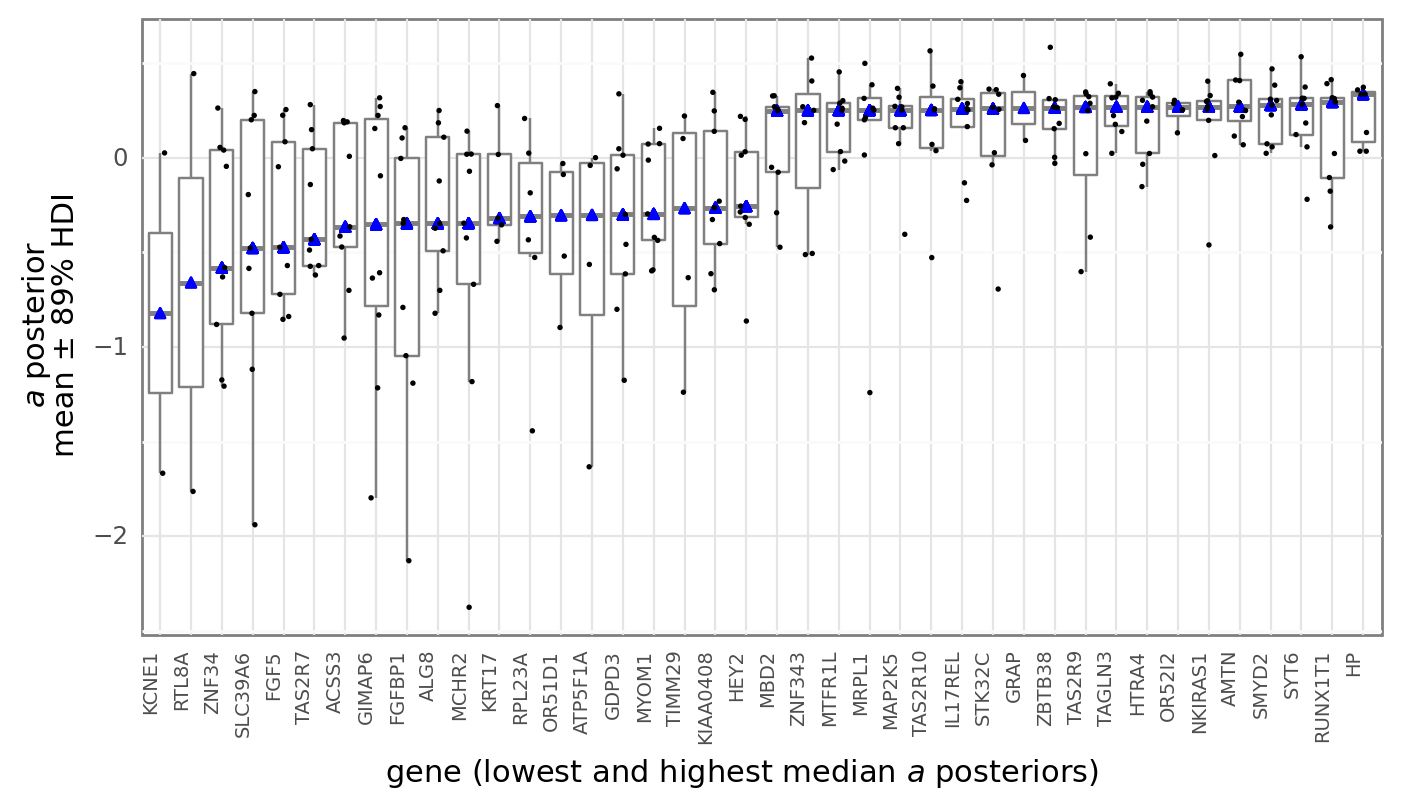

<ggplot: (364752306)>

In [19]:
(
    gg.ggplot(a_post_gene_avg_minmax, gg.aes(x="hugo_symbol"))
    + gg.geom_boxplot(gg.aes(y="mean"), outlier_alpha=0, color="gray")
    + gg.geom_point(gg.aes(y="gene_mean"), shape="^", color="blue")
    + gg.geom_jitter(gg.aes(y="mean"), width=0.2, height=0, size=0.1)
    + gg.theme(
        figure_size=(8, 4), axis_text_x=gg.element_text(angle=90, size=7, hjust=1)
    )
    + gg.labs(
        x="gene (lowest and highest median $a$ posteriors)",
        y="$a$ posterior\nmean ± 89% HDI",
    )
)

#### $d$: gene $\times$ lineage

In [20]:
d_posterior = posterior_summary.query("parameter_name == 'd'").reset_index(drop=True)

_idx = np.asarray(
    [x.replace("]", "").split("[")[1].split(",") for x in d_posterior.parameter],
    dtype=int,
)
d_posterior["hugo_symbol"] = [data_coords["gene"][i] for i in _idx[:, 0]]
d_posterior["lineage"] = [data_coords["lineage"][i] for i in _idx[:, 1]]


d_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,hugo_symbol,lineage
0,"d[0,0]",-0.002,0.038,-0.059,0.060,0.001,0.001,973.0,2159.0,1.00,d,GUK1,colorectal
1,"d[0,1]",0.025,0.037,-0.035,0.083,0.001,0.001,911.0,1550.0,1.00,d,GUK1,bone
2,"d[1,0]",-0.001,0.038,-0.059,0.062,0.001,0.001,1319.0,2430.0,1.01,d,HSDL2,colorectal
3,"d[1,1]",0.006,0.038,-0.058,0.065,0.001,0.001,1263.0,2169.0,1.01,d,HSDL2,bone
4,"d[2,0]",-0.012,0.041,-0.073,0.057,0.001,0.001,2434.0,2330.0,1.00,d,AMY2A,colorectal


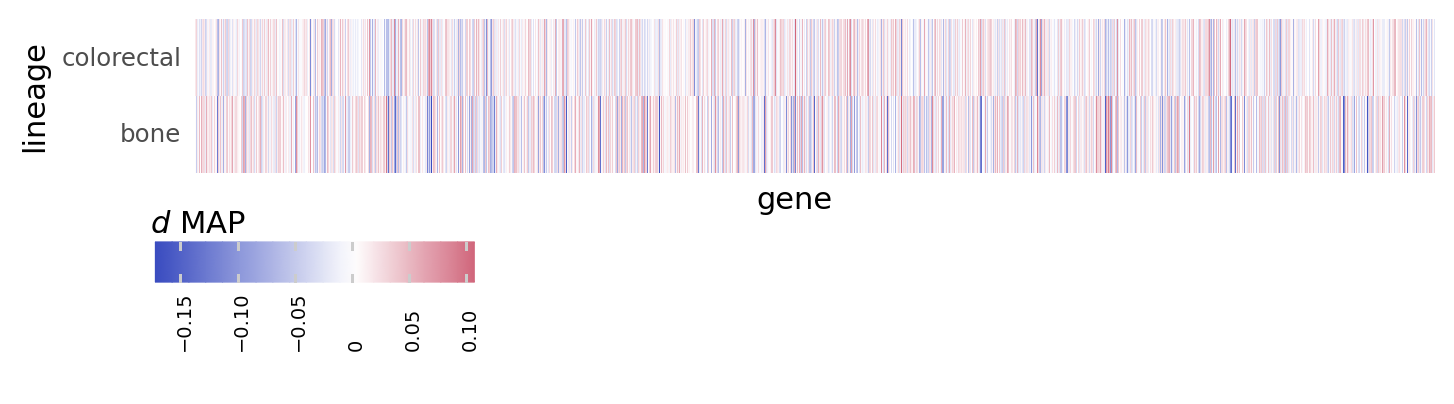

<ggplot: (363692849)>

In [21]:
(
    gg.ggplot(d_posterior, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A4CC0", high="#B30326")
    + gg.theme(
        figure_size=(8, 1),
        axis_text_x=gg.element_blank(),
        legend_position=(0.2, -0.4),
        legend_direction="horizontal",
        legend_key_width=10,
        legend_background=gg.element_blank(),
        legend_text=gg.element_text(angle=90, size=7, va="bottom"),
        panel_background=gg.element_blank(),
        panel_border=gg.element_blank(),
    )
    + gg.labs(x="gene", y="lineage", fill="$d$ MAP")
)

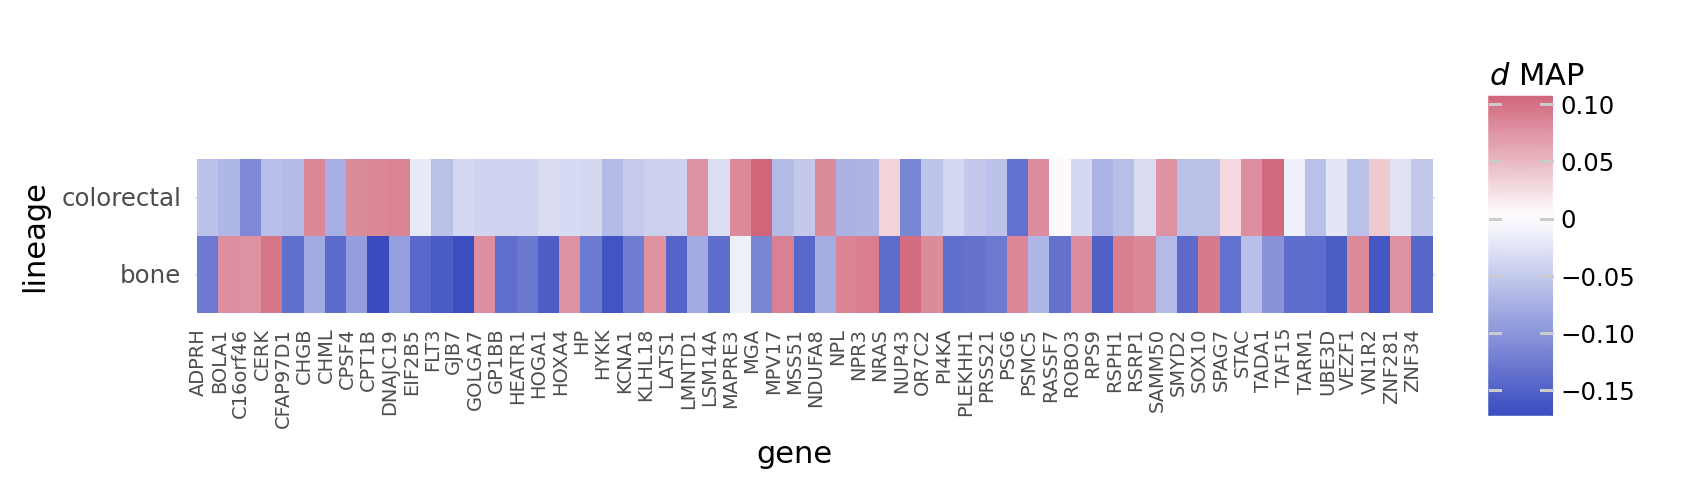

<ggplot: (352260151)>

In [22]:
top_d_genes = d_posterior.sort_values("mean").pipe(min_max, n=30).hugo_symbol.unique()
d_posterior_top = d_posterior.filter_column_isin("hugo_symbol", top_d_genes)

(
    gg.ggplot(d_posterior_top, gg.aes(x="hugo_symbol", y="lineage"))
    + gg.geom_tile(gg.aes(fill="mean"), color=None)
    + gg.scale_y_discrete(expand=(0, 0.5))
    + gg.scale_fill_gradient2(low="#3A4CC0", high="#B30326")
    + gg.theme(
        figure_size=(8, 1),
        axis_text_x=gg.element_text(angle=90, hjust=1, size=7),
        panel_background=gg.element_blank(),
        panel_border=gg.element_blank(),
    )
    + gg.labs(x="gene", y="lineage", fill="$d$ MAP")
)

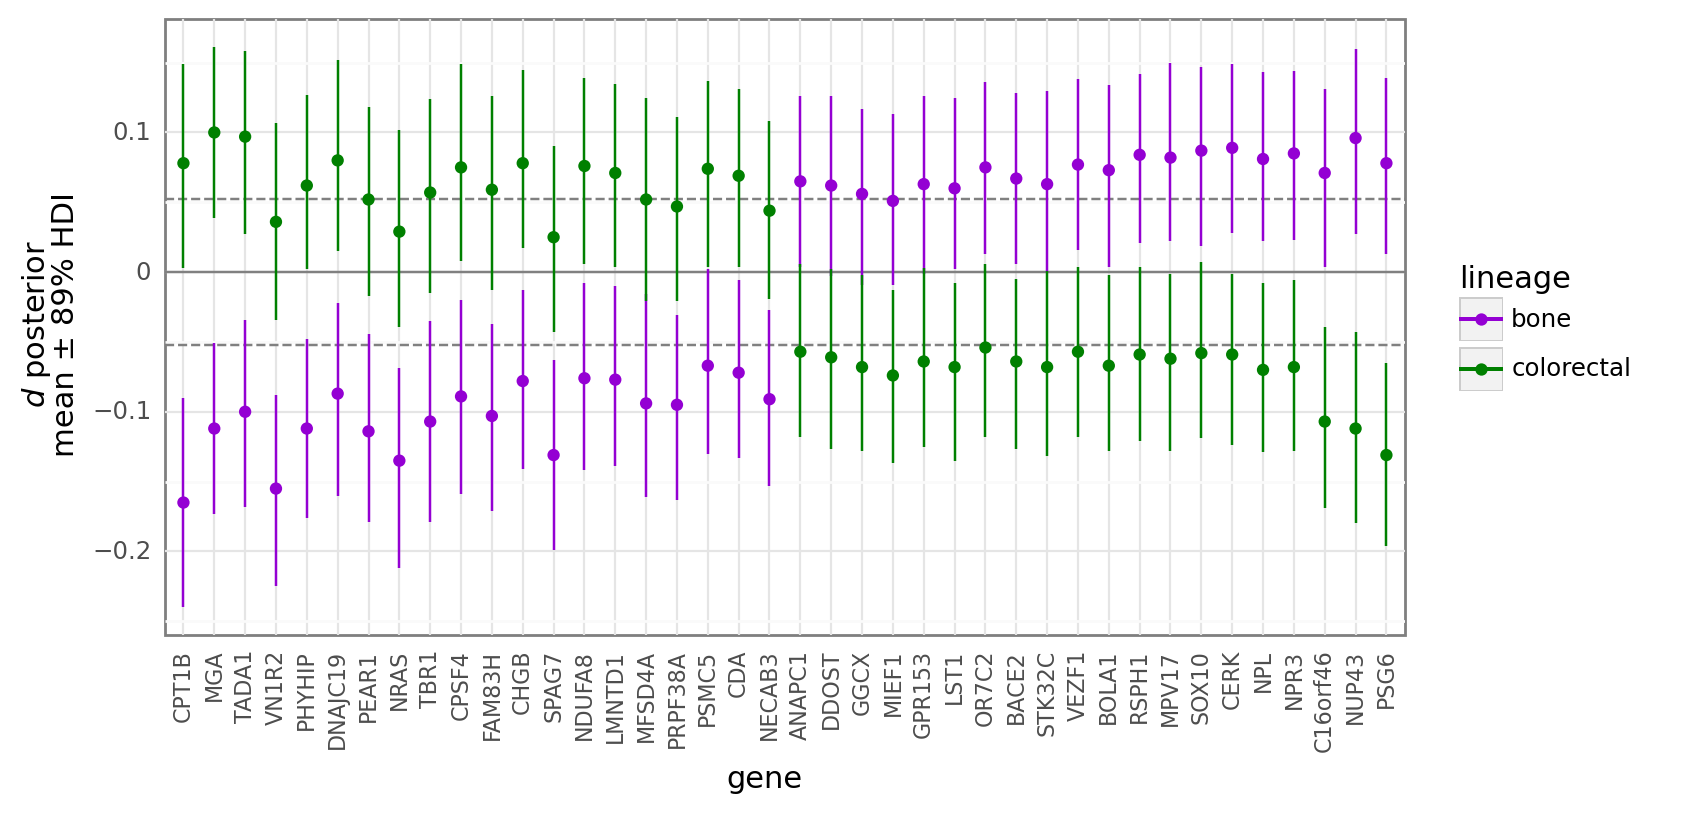

<ggplot: (365251313)>

In [23]:
sigma_d_map = posterior_summary.query("parameter== 'sigma_d'")["mean"].values[0]

d_posterior_diff = (
    d_posterior[["mean", "hugo_symbol", "lineage"]]
    .pivot_wider(index="hugo_symbol", names_from="lineage", values_from="mean")
    .assign(diff=lambda d: d.bone - d.colorectal)
)

most_diff_d = (
    d_posterior_diff.sort_values("diff").pipe(min_max, n=20).hugo_symbol.values
)

plot_df = d_posterior.filter_column_isin("hugo_symbol", most_diff_d).assign(
    hugo_symbol=lambda d: pd.Categorical(
        d.hugo_symbol, categories=most_diff_d, ordered=True
    )
)

(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="mean", color="lineage"))
    + gg.geom_hline(yintercept=0, color="gray")
    + gg.geom_hline(yintercept=[-sigma_d_map, sigma_d_map], linetype="--", color="gray")
    + gg.geom_linerange(gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%"))
    + gg.geom_point()
    + gg.scale_color_manual(values=lineage_pal)
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(8, 4))
    + gg.labs(x="gene", y="$d$ posterior\nmean ± 89% HDI")
)

/usr/local/Caskroom/miniconda/base/envs/speclet/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 189 rows containing non-finite values.


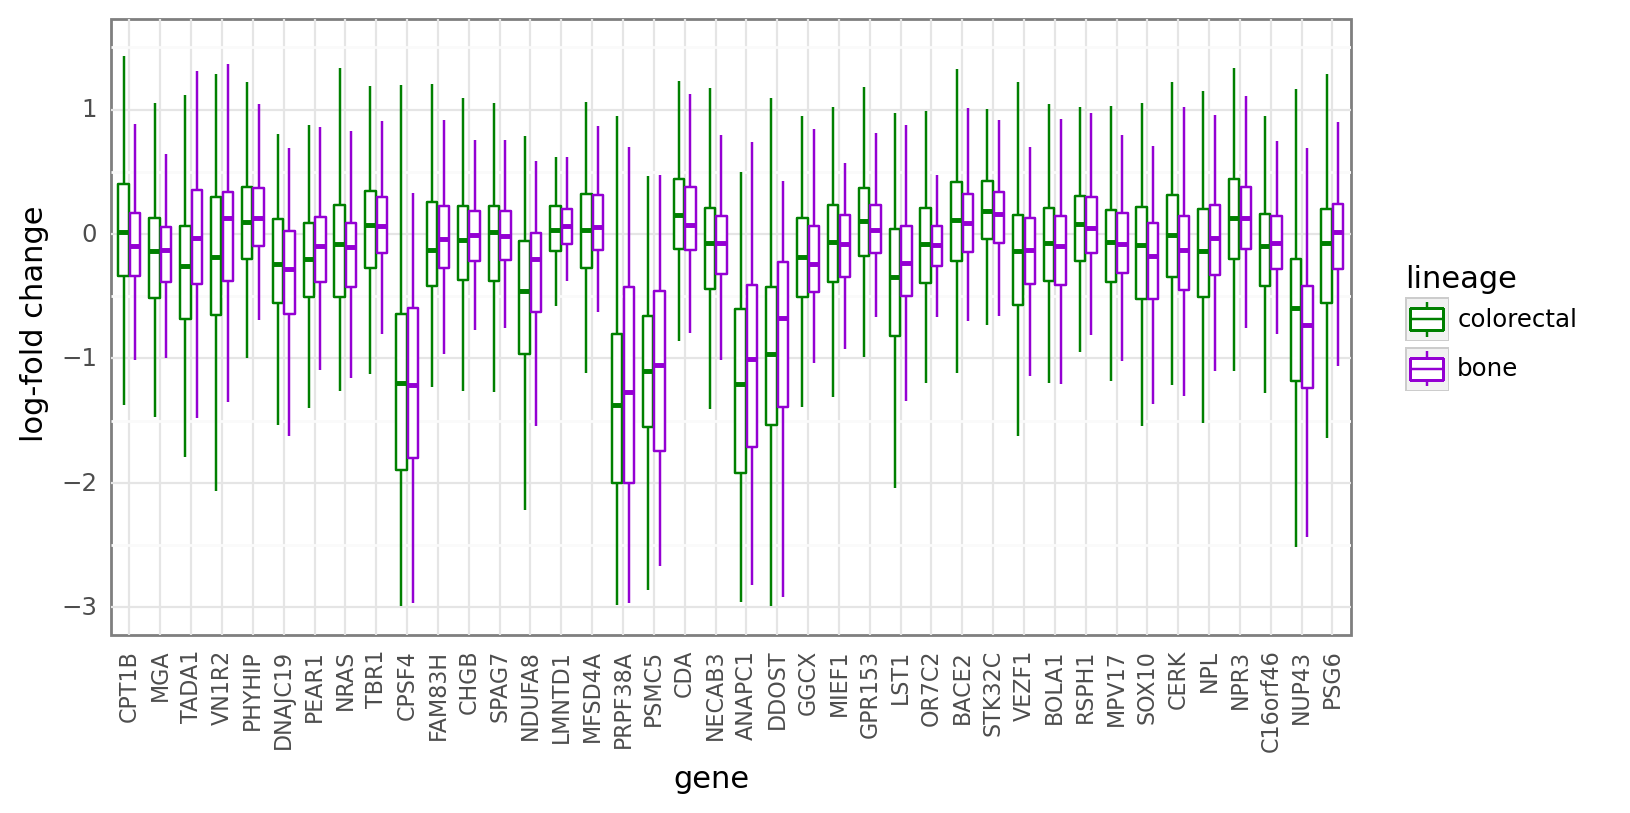

<ggplot: (365230689)>

In [24]:
plot_df = counts_data.filter_column_isin("hugo_symbol", most_diff_d).assign(
    hugo_symbol=lambda d: pd.Categorical(
        d.hugo_symbol, categories=most_diff_d, ordered=True
    )
)
(
    gg.ggplot(plot_df, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_boxplot(gg.aes(color="lineage"), outlier_alpha=0)
    + gg.scale_color_manual(values=lineage_pal)
    + gg.scale_y_continuous(limits=(-3, 1.5))
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=8), figure_size=(8, 4))
    + gg.labs(x="gene", y="log-fold change")
)

#### $\alpha$: gene dispersion

In [25]:
posterior_summary.filter_string("parameter_name", "_alpha")

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name
21045,alpha_alpha,3.680,0.110,3.512,3.866,0.002,0.001,3324.0,3128.0,1.0,alpha_alpha
21046,beta_alpha,0.529,0.017,0.501,0.555,0.000,0.000,3341.0,2910.0,1.0,beta_alpha


In [26]:
x = np.linspace(0, 20, 500)
alpha = posterior_summary.query("parameter_name == 'alpha_alpha'")["mean"].values[0]
beta = posterior_summary.query("parameter_name == 'beta_alpha'")["mean"].values[0]
pdf = st.gamma.pdf(x, alpha, scale=1.0 / beta)

alpha_parent_dist = pd.DataFrame({"x": x, "pdf": pdf})

In [27]:
alpha_posterior = (
    posterior_summary.query("parameter_name == 'alpha'")
    .reset_index(drop=True)
    .assign(hugo_symbol=data_coords["gene"])
)
alpha_posterior.head()

,parameter,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,parameter_name,hugo_symbol
0,alpha[0],11.514,0.761,10.304,12.702,0.009,0.006,8002.0,2752.0,1.0,alpha,GUK1
1,alpha[1],9.574,0.647,8.579,10.636,0.008,0.006,6600.0,2627.0,1.0,alpha,HSDL2
2,alpha[2],4.555,0.312,4.098,5.082,0.004,0.003,6702.0,2841.0,1.0,alpha,AMY2A
3,alpha[3],8.987,0.592,8.066,9.936,0.007,0.005,6803.0,2756.0,1.0,alpha,HDAC5
4,alpha[4],9.101,0.582,8.174,10.002,0.007,0.005,6317.0,2917.0,1.0,alpha,FOXP2


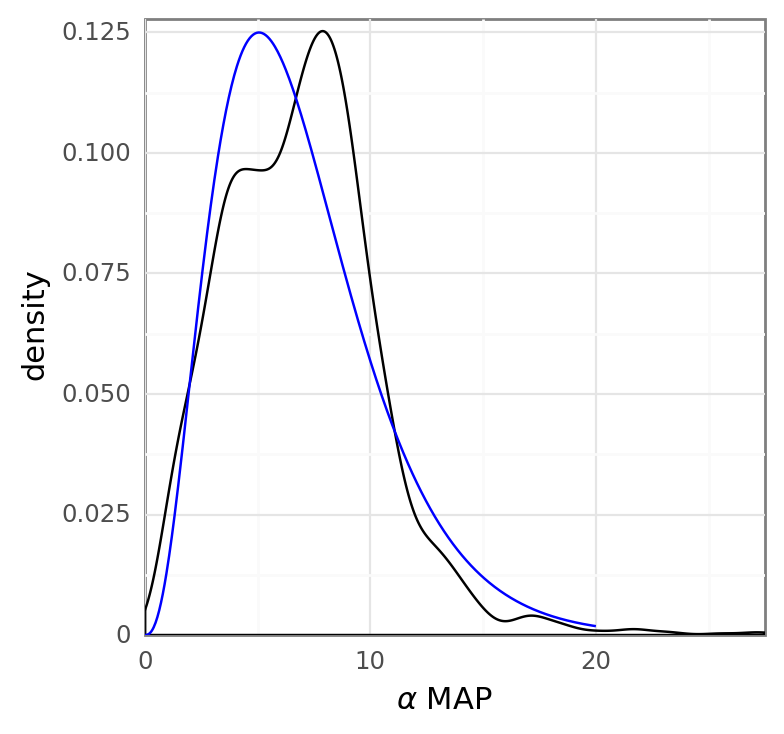

<ggplot: (365991096)>

In [28]:
(
    gg.ggplot(alpha_posterior, gg.aes(x="mean"))
    + gg.geom_density()
    + gg.geom_line(gg.aes(x="x", y="pdf"), data=alpha_parent_dist, color="blue")
    + gg.scale_x_continuous(expand=(0, 0))
    + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
    + gg.labs(x="$\\alpha$ MAP")
)

---

In [29]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1.40 minutes


In [30]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-08

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.2.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: theano-blas-warning

pandas    : 1.3.5
seaborn   : 0.11.2
numpy     : 1.22.0
scipy     : 1.7.3
pymc3     : 3.11.4
arviz     : 0.11.4
plotnine  : 0.8.0
matplotlib: 3.5.1

